In [1]:
!pip install librosa==0.7.2

     |████████████████████████████████| 1.6MB 5.0MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=5cbb6f4138fb49b68e91d9ef60b37a2ce271dd479044487b121121f157dbdb49
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [2]:
import os
import time
import glob
from typing import Tuple

from google.colab import drive

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, \
  Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, \
  LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, \
  Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K

import librosa
import librosa.display
import librosa.feature
import librosa.output

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import clear_output

# Setup

In [3]:
drive.mount('/gdrive/')
!ls '/gdrive/My Drive/bosch/processed-instr/acoustic' | head -10

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/
00rmsjfesXsyNfQJpGKm98.npy
01MVOl9KtVTNfFiBU9I7dc.npy
01pgHbtziFmLnaIdTbz3FK.npy
01yPhHRM0V95CenZmFQKjw.npy
02a2RQEICEzbdPPYh0aLnJ.npy
02acUMylPHMjJ9miDc9b38.npy
02YOoeVLNbzr13bq5NhObP.npy
037MkSfM6EbJn1xAWccahC.npy
03czT1nVZDRv2JlpY2GxON.npy
03kCR9HZpX5muU7D8xYPOL.npy


In [4]:
arr = np.load('/gdrive/My Drive/bosch/processed-instr/acoustic/1vqZyZ5lidDFBE0Jfa9sLq.npy')
arr.shape

(128, 1292)

In [5]:
H = 128
W = 1290
C = 1

SIAM_VEC_LEN = 128
DELTA_SIAM = 2.          # Siamese constant
BATCH_SIZE = 16
SAMPLES = 5           # Divide each HxW spectogram in `SAMPLES` spectograms of equal width     
SR = 22050

# Reference values to normalize data
min_level_db=-100
ref_level_db=20

assert W % SAMPLES == 0
assert (W // SAMPLES) % 3 == 0

WEIGHTS_PATH = '/gdrive/My Drive/bosch/weights'
ROOT_DIR = '/gdrive/My Drive/bosch/processed-instr'
BOSCH_DIR = '/gdrive/My Drive/bosch'
FROM_GENRE = 'jazz'
TO_GENRE = 'classical'

# Spectral Normalization

In [6]:
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape


def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)

class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs

# Network Architecture

## Layer Helper

In [7]:
init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

## Generator

In [8]:
#U-NET style architecture
def build_generator(input_shape):
  h, w, c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  print('G0', g0.shape)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  print('G1', g1.shape)
  g1_p = tf.keras.layers.ZeroPadding2D((0,1))(g1)
  g2 = conv2d(g1_p, 256, kernel_size=(1,9), strides=(1,2))
  print('G2', g2.shape)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  print('G3', g3.shape)
  #upscaling
  g4 = deconv2d(g3, g2, 256, kernel_size=(1,7), strides=(1,2))
  print('G4', g4.shape)
  g5 = deconv2d(g4, tf.keras.layers.ZeroPadding2D((0,1))(g1), 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  print('G5', g5.shape)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), activation='tanh', kernel_initializer=init, padding='valid')(g5)
  print('G6', g6.shape)
  g7 = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 1)))(g6)
  print('G7', g7.shape)
  return Model(inp, g7, name='G')

## Critic

In [9]:
#Discriminator (Critic) Network
def build_critic(input_shape):
  h, w, c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

## Siamese

In [10]:
#Siamese Network
def build_siamese(input_shape):
  h, w, c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  g4 = Flatten()(g3)
  g5 = Dense(SIAM_VEC_LEN)(g4)
  return Model(inp, g5, name='S')

# Network Setup

In [11]:
def build_gan(load_save: bool = True) -> 'Tuple[Generator, Critic, Siamese]':
  """
  Serve the GAN system.
  Params:
    input_shape: Shape of the input tensor for the GAN.
    load_save: True if the system should load the network from disk.
  Warning:
    Setting `load_save` to False will erase any progress, since
    weights are always overwritten.
  """
  gen = build_generator((H, W // SAMPLES // 3, C))
  siam = build_siamese((H, W // SAMPLES // 3, C))
  crit = build_critic((H, W // SAMPLES, C))
  if load_save and len(glob.glob(f'{WEIGHTS_PATH}/*.h5')) != 0:
    # Load only if there are saved weights in the directory
    print('FOUND WEIGHTS, LOADING..')
    gen.load_weights(f'{WEIGHTS_PATH}/gen.h5')
    siam.load_weights(f'{WEIGHTS_PATH}/siam.h5')
    crit.load_weights(f'{WEIGHTS_PATH}/crit.h5')
  return gen, crit, siam

In [12]:
gen, crit, siam = build_gan(load_save=True)

G0 (None, 128, 88, 1)
G1 (None, 1, 86, 256)
G2 (None, 1, 44, 256)
G3 (None, 1, 22, 256)
G4 (None, 1, 44, 512)
G5 (None, 1, 88, 512)
G6 (None, 128, 88, 1)
G7 (None, 128, 86, 1)
FOUND WEIGHTS, LOADING..


In [13]:
opt_gen = tf.keras.optimizers.Adam(0.0001, 0.5)
opt_disc = tf.keras.optimizers.Adam(0.0001, 0.5)

# Dataset Preparation

In [41]:
def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.) - 1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1) + 1.) / 2.) * -min_level_db) + min_level_db

def prep(S: np.array):
  S_db = librosa.power_to_db(S) - ref_level_db
  return normalize(S_db)

def deprep(S):
  S = denormalize(S) + ref_level_db
  S = librosa.db_to_power(S)
  return librosa.feature.inverse.mel_to_audio(S)

In [15]:
FNS_TO_LOAD = 300

filenames_a = [f'{ROOT_DIR}/{FROM_GENRE}/{fn}' for fn in os.listdir(f'{ROOT_DIR}/{FROM_GENRE}')]
filenames_b = [f'{ROOT_DIR}/{TO_GENRE}/{fn}' for fn in os.listdir(f'{ROOT_DIR}/{TO_GENRE}')]

assert len(filenames_a) >= FNS_TO_LOAD
assert len(filenames_b) >= FNS_TO_LOAD

adata = [np.expand_dims(np.load(fn)[:, :1290], axis=2) for fn in filenames_a[:FNS_TO_LOAD]]
bdata = [np.expand_dims(np.load(fn)[:, :1290], axis=2) for fn in filenames_b[:FNS_TO_LOAD]]

adata = [prep(split_a) for a in adata for split_a in np.split(a, SAMPLES, axis=1)]
bdata = [prep(split_b) for b in bdata for split_b in np.split(b, SAMPLES, axis=1)]

assert adata[0].shape == (128, W // SAMPLES, 1)

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(25).shuffle(100000).batch(BATCH_SIZE, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(25).shuffle(100000).batch(BATCH_SIZE, drop_remainder=True)

# Training

In [16]:
def unpack_spectogram(im: 'Tensor') -> Tuple['Tensor', 'Tensor', 'Tensor']:
  """Split spectogram into 3 equal parts."""
  
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

def assemble_spectogram(lsim: Tuple['Tensor', 'Tensor', 'Tensor']) -> 'Tensor':
  """Reassamble the original spectogram."""
  im1, im2, im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

In [17]:
def plot_melspectogram(S: np.array, title: str):
  plt.figure(figsize=(8, 6))
  # S_dB = librosa.power_to_db(S, ref=np.max)
  S = denormalize(S) + ref_level_db
  librosa.display.specshow(S, x_axis='time',
                             y_axis='mel', sr=22050,
                            fmax=8000)
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)
  plt.tight_layout()
  plt.show()

In [18]:
def mae(x, y):
  """Calculate L1 error between given vectors."""
  return tf.reduce_mean(tf.abs(x-y))

def mse(x, y):
  """Calculate L2 error between given vectors."""
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa, sab, sa1, sab1):
  """
  Calculate the TRAVEL distance.
  Minimising the distance equals to obtaining vectors of similar magnitude
  and amplitude in the latent space of A distribution and B distribution.
  Params:
    siamese_latent_vector: Vector from latent space A.
    siamese_generated_vector: Vector from latent space B.
  """
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa, sa1):
  """
  Margin loss in order to avoid Siamese learning trivial functions.
  Creates a meaningful latent space by keeping generated vectors apart.
  Else S will map every vector to the same position.
  """
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((DELTA_SIAM - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [19]:
@tf.function
def train_step(a, b, batch_idx, train_only_step):
  """
  Train the GAN System.
  Params:
    a (tf.Tensor): Vector from distribution A to be transformed.
    b (tf.Tensor): Vector from distribution B for critic training.
  """
  aa, aa2, aa3 = unpack_spectogram(a)
  bb, bb2, bb3 = unpack_spectogram(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
    # Generate fake image
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_spectogram([fab,fab2,fab3])

    # Identity mapping 
    fid = gen(bb, training=True) 
    fid2 = gen(bb2, training=True)
    fid3 = gen(bb3, training=True)

    # Feed the fake and authentic to the critic
    cab = crit(fabtot, training=True)
    cb = crit(b, training=True)

    # Siamese
    # Feed 2 pairs (A, G(A)) extracted spectrograms to Siamese
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)

    # Identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3. 
    # TRAVEL loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    # Generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    # Generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id   

    # Compute and apply gradient
    if batch_idx % train_only_step == 0:  
      grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
      opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, crit.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, crit.trainable_variables))

    return loss_dr, loss_df, loss_g, loss_id

In [20]:
def train(epochs: int, lr=0.0001, save_step=1, display_step=50):
  """
  Training loop for GAN system.
  Params:
    epochs: How many steps should we train.
    batch_size: How many spectograms to process every train step.
    lr: Learning rate
    all_step: Train all 3 networks every n-th step, otherwise train only c.
    save_step: Number of epochs between saving model to disk.
    display_step: Log model performance every `display_step` batches.
  """
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

  disc_fake_list = []
  disc_real_list = []
  gen_list = []
  id_list = []
  g = 0
  nbatch = 1

  global dsa
  global dsb

  for epoch in range(epochs):
    start_time = time.time()
    d_total, acc_f_d, acc_r_d = 0, 0, 0

    for batch_idx, (a, b) in enumerate(zip(dsa, dsb)):

      loss_d_real, loss_d_fake, loss_gen, loss_id = train_step(a, b, tf.constant(batch_idx), tf.constant(6))
      
      disc_fake_list.append(loss_d_fake)
      disc_real_list.append(loss_d_real)
      id_list.append(loss_id)
      gen_list.append(loss_gen)
      g += 1

      nbatch = batch_idx + 1
      if nbatch % display_step == 0:
        print(f'[Epoch {epoch}/{epochs}] [Batch {nbatch}] [D loss fake: {np.mean(disc_fake_list[-g:], axis=0)} ', end='')
        print(f'real: {np.mean(disc_real_list[-g:], axis=0)}] ', end='')
        print(f'[G loss: {np.mean(gen_list[-g:], axis=0)}] ', end='')
        print(f'[G id loss: {np.mean(id_list[-g:], axis=0)}]', end='')
        print(f'[LR: {lr}]')
        g = 0
        print(f'Time/Batch {(time.time()-start_time)/nbatch}')

    if (epoch + 1) % save_step == 0:
      gen.save_weights(f'{WEIGHTS_PATH}/gen.h5')
      siam.save_weights(f'{WEIGHTS_PATH}/siam.h5')
      crit.save_weights(f'{WEIGHTS_PATH}/crit.h5')
      print(f'CHECKPOINT EPOCH {epoch + 1}')

    clear_output(wait=True)
    plot_melspectogram(a[0, :, :, 0], 'A sample')
    plot_melspectogram(b[0, :, :, 0], 'B sample')
    aa, aa2, aa3 = unpack_spectogram(a)
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_spectogram([fab,fab2,fab3])
    plot_melspectogram(fabtot[0, :, :, 0], 'Generated')

In [21]:
# train(2000, lr=0.0002, display_step=100)

# Testing

In [22]:
!ls '/gdrive/My Drive/bosch/processed-instr/jazz' | head -10

00t78SKl7PHj3KfQ54fenL.npy
013vhwBqoO9GHoKhsviiyG.npy
01Tjw4oDG8jZgb1sZ59Uar.npy
02uRToy7bttYcKCO3vIStA.npy
0301nLjG0ti26rx5ZmfqtP.npy
03k3pTFdvFcZIyt6WgNIL4.npy
03RHLun8Ni9yFjA7vNGOkY.npy
03Wma4AcL2NXi0HPqhKJ1v.npy
0488kXJ1YnLMrrM1ssJnev.npy
049VqBETqY4gIRJuOJyQuF.npy


In [23]:
target_fn = '00t78SKl7PHj3KfQ54fenL.npy' 

In [24]:
# target_fn = '00t78SKl7PHj3KfQ54fenL.npy' 

In [25]:
# input_tensor = prepare_from_track(target_fn)
# output_tensor = gen(input_tensor)[0, :, :, 0]

In [26]:
#  output_wav = librosa.feature.inverse.mel_to_audio(output_tensor.numpy())
#  librosa.output.write_wav(f'{BOSCH_DIR}/output.wav', output_wav, sr=SR)

In [47]:
crit.summary()

Model: "C"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 258, 1)]     0         
_________________________________________________________________
conv_s_n2d_8 (ConvSN2D)      (None, 1, 256, 512)       197120    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1, 256, 512)       0         
_________________________________________________________________
conv_s_n2d_9 (ConvSN2D)      (None, 1, 128, 512)       2359808   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1, 128, 512)       0         
_________________________________________________________________
conv_s_n2d_10 (ConvSN2D)     (None, 1, 64, 512)        1835520   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1, 64, 512)        0         

In [28]:
# tf.keras.utils.plot_model(gen, to_file='generator.png')

In [34]:
!ls /gdrive/My\ Drive/bosch

cat.jpg  devoicing  model.pt	processed	 processed-voc	starry.jpg
data	 frog.jpg   output.wav	processed-instr  results	weights


In [64]:
# Take one batch
result_dsa = dsa.skip(10).take(1)

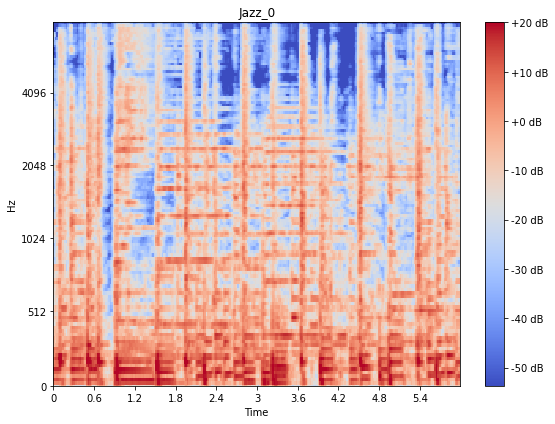

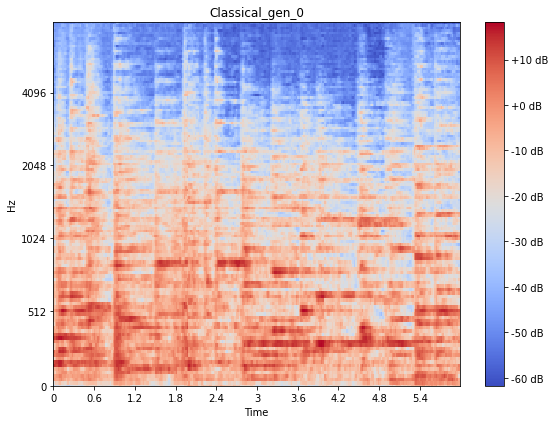

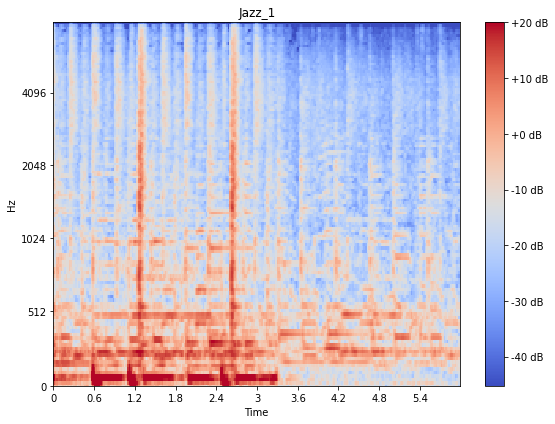

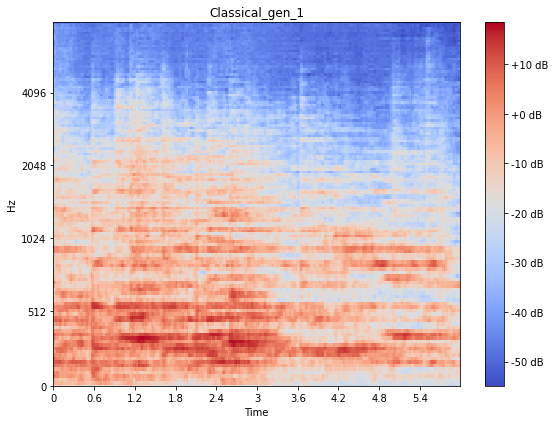

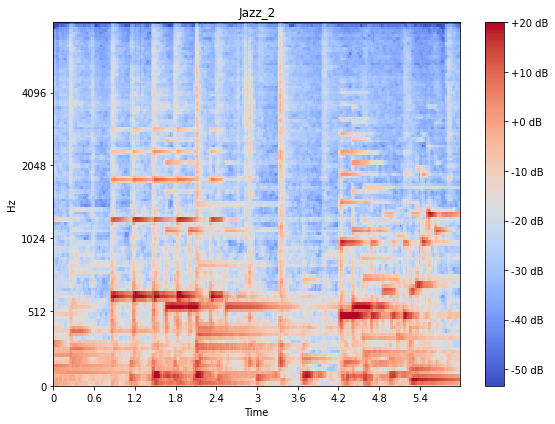

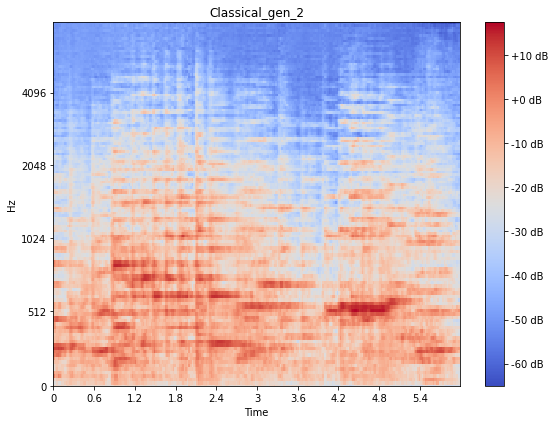

In [65]:
sound = []
for (a, b) in zip(result_dsa, result_dsb):
  aa, aa2, aa3 = unpack_spectogram(a)

  fab = gen(aa)
  fab2 = gen(aa2)
  fab3 = gen(aa3)
  fabtot = assemble_spectogram([fab,fab2,fab3])
  for i in range(3):
    plot_melspectogram(a[i, :, :, 0], f'Jazz_{i}')
    plot_melspectogram(fabtot[i, :, :, 0], f'Classical_gen_{i}')
  for i in range(3):
    g_audio = deprep(fabtot[i, :, :, 0])
    a_audio = deprep(a[i, :, :, 0])
    sound.append((a_audio, g_audio))

In [45]:
sound

[(array([ 0.02114735,  0.04953431,  0.06958458, ..., -0.0979991 ,
         -0.09275253, -0.12198786], dtype=float32),
  array([0.05301289, 0.06815784, 0.06175517, ..., 0.04830553, 0.05528584,
         0.05400434], dtype=float32)),
 (array([ 0.09550172,  0.10522145,  0.10009641, ..., -0.13587314,
         -0.13802664, -0.10800314], dtype=float32),
  array([-0.05207514, -0.04345886, -0.02790173, ...,  0.00640957,
          0.0089513 ,  0.00813892], dtype=float32)),
 (array([0.00149014, 0.00147841, 0.0014056 , ..., 0.13929136, 0.15763114,
         0.17129138], dtype=float32),
  array([0.001223  , 0.00190185, 0.00173947, ..., 0.08145089, 0.08040794,
         0.07852146], dtype=float32))]

In [56]:
!ls /gdrive/My\ Drive/bosch/results/

generated  initial


In [67]:
for idx, (a, g) in enumerate(sound):
  librosa.output.write_wav(f'/gdrive/My Drive/bosch/results/generated/{idx}.wav', g, SR)
  librosa.output.write_wav(f'/gdrive/My Drive/bosch/results/initial/{idx}.wav', a, SR)